In [1]:
from nn_hmc_3d import NN_HMC
import dill
import numpy as np
import IPython
import jax.random as random
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import h5py
from igm_emulator.emulator.plotVis import v_bins
from igm_emulator.emulator.emulator_run import nn_emulator
import os
'''
load model and auto-corr
'''
redshift = 5.4

# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
in_path_hdf5 = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/'
f = h5py.File(in_path_hdf5 + f'z{redshift}_nn_savefile.hdf5', 'r')
emu_name = f'{z_string}_best_param_training_768.p'
#IPython.embed()

best_params = dill.load(open(in_path_hdf5 + emu_name, 'rb'))
meanX = np.asarray(f['data']['meanX'])
stdX = np.asarray(f['data']['stdX'])
meanY = np.asarray(f['data']['meanY'])
stdY =  np.asarray(f['data']['stdY'])
print(meanX)
#best_params = load(f)
#print(f['performance']['residuals'])
#print(f['best_params']['custom_linear/~/linear_0']['w'])
#print(load(f'/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/z{redshift}_nn_savefile.hdf5'))

in_path = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'
n_paths = np.array([17, 16, 16, 15, 15, 15, 14])
n_path = n_paths[z_idx]
vbins = v_bins
param_in_path = '/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/'
param_dict = dill.load(open(param_in_path + f'{z_string}_params.p', 'rb'))

fobs = param_dict['fobs']  # average observed flux <F> ~ Gamma_HI
log_T0s = param_dict['log_T0s']  # log(T_0) from temperature - density relation
T0s = np.exp(log_T0s)
gammas = param_dict['gammas']  # gamma from temperature - density relation

T0_idx = 11 #0-14
g_idx = 4 #0-8
f_idx = 7 #0-8

like_name = f'likelihood_dicts_R_30000_nf_9_T{T0_idx}_G{g_idx}_SNR0_F{f_idx}_ncovar_500000_P{n_path}_set_bins_4.p'
like_dict = dill.load(open(in_path + like_name, 'rb'))
theta_true = [fobs[f_idx], T0s[T0_idx], gammas[g_idx]]
print(T0s)

Layers: [100, 100, 100, 276]
Activation: <function leaky_relu at 0x7f0aa5702ea0>
L2 regularization lambda: 0.0001
meanX = [8.400e-02 9.149e+03 1.352e+00]
stdX = [1.36930639e-02 5.50374022e+03 6.02494813e-01]
train: (768, 3)
(358, 276)
[8.400e-02 9.149e+03 1.352e+00]
[12.71554711 24.67484172 31.71737654 37.1492057  41.70354711 45.68738523
 49.26329178 52.52943229 55.55034817 58.3711006  61.02459133 63.5356931
 65.92373836 68.20409855 70.38922923]


In [2]:
print(theta_true)

[0.099, 63.53569309711353, 1.3520000000000003]


In [3]:
theta=jnp.array([theta_true,theta_true,theta_true])
theta_i=theta.squeeze()
print(theta)
print(theta.shape)
print(theta_i.shape)

[[ 0.099     63.5356931  1.352    ]
 [ 0.099     63.5356931  1.352    ]
 [ 0.099     63.5356931  1.352    ]]
(3, 3)
(3, 3)


<class 'list'>


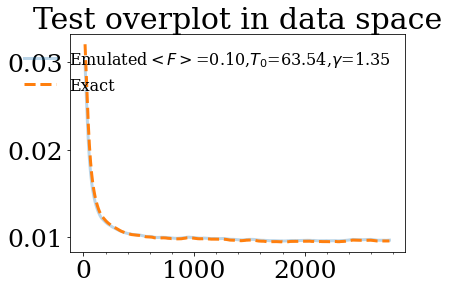

In [4]:
flux = like_dict['mean_data']
print(type(theta_true))

model = nn_emulator(best_params, theta_true)

fig2, axs2 = plt.subplots(1, 1)
axs2.plot(vbins, model, label=f'Emulated' r'$<F>$='f'{theta_true[0]:.2f},'
                                                     r'$T_0$='f'{theta_true[1]:.2f},'
                                                     r'$\gamma$='f'{theta_true[2]:.2f}', alpha=0.3)
axs2.plot(vbins, flux, label=f'Exact', linestyle='--')
plt.title('Test overplot in data space')
plt.legend()
plt.show()

In [17]:
    nn = NN_HMC(vbins,best_params,T0s,gammas,fobs,like_dict)
    key = random.PRNGKey(642)
    key, subkey = random.split(key)
    x_true = nn.theta_to_x(theta_true)
    x_samples, theta_samples, ln_probs, neff, neff_mean, \
    sec_per_neff, ms_per_step, r_hat, r_hat_mean, \
    hmc_num_steps, hmc_tree_depth, runtime = nn.mcmc_one(key, x_true, flux)

true theta:[1.94591015e+00 2.00352811e+00 4.44089210e-16]
true x:[ 16.11809555 -16.11809555 -16.11809555]
init pos:[[ 1.94618550e+00  2.00342759e+00 -3.56335812e-05]
 [ 1.94594108e+00  2.00358043e+00 -4.62127719e-05]
 [ 1.94586258e+00  2.00353492e+00 -1.20188824e-04]
 [ 1.94587568e+00  2.00355075e+00 -1.20464447e-05]
 [ 1.94601481e+00  2.00347170e+00  9.72270665e-05]
 [ 1.94586779e+00  2.00353563e+00  3.80385767e-06]
 [ 1.94586975e+00  2.00347229e+00 -7.06144448e-05]
 [ 1.94588392e+00  2.00367185e+00  1.13255306e-05]
 [ 1.94594721e+00  2.00334909e+00 -9.89052354e-05]
 [ 1.94594278e+00  2.00350083e+00  1.01294167e-04]
 [ 1.94583933e+00  2.00356703e+00  8.25421101e-05]
 [ 1.94597192e+00  2.00344458e+00 -2.83445266e-05]
 [ 1.94564450e+00  2.00343682e+00  3.20195919e-05]
 [ 1.94596068e+00  2.00349008e+00 -4.13594069e-05]
 [ 1.94598083e+00  2.00341684e+00 -1.40147805e-05]
 [ 1.94601289e+00  2.00355723e+00 -3.04735449e-05]]


sample: 100%|██████████| 2000/2000 [11:05<00:00,  3.01it/s]


*** SUMMARY FOR HMC ***
total_time = 675.7444155216217 seconds for the HMC
total_steps = 307819 total steps
ms_per_step = 2.195265449896276 ms per step of the HMC
n_eff_mean = 3456.6666666666665 effective sample size, compared to ntot = 16000 total samples.
sec_per_neff = 0.195 seconds per effective sample
r_hat_mean = 1.0966666666666667
max_tree_depth encountered = 10 in chain
There were 181 transitions that exceeded the max_tree_depth = 10
*************************


In [6]:
import sys
sys.path.append('/home/zhenyujin/dw_inference/dw_inference/inference')
from utils import walker_plot, corner_plot
note = "jit_2000_16_test8_vec_physical_xprior"

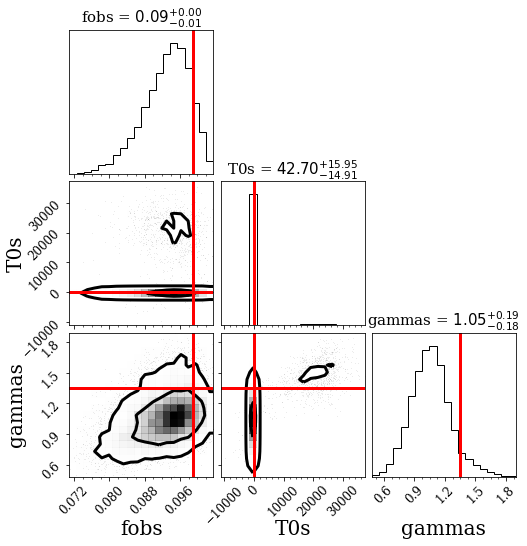

In [7]:
var_label = ['fobs', 'T0s', 'gammas']
corner_plot(theta_samples, var_label,
            theta_true=jnp.asarray(theta_true),
            overlay_color = ['k'])

In [8]:
print(theta_samples.shape,
x_samples.shape,
np.swapaxes(jnp.asarray(x_samples), 0, 1).shape)

(16000, 3) (16, 1000, 3) (1000, 16, 3)


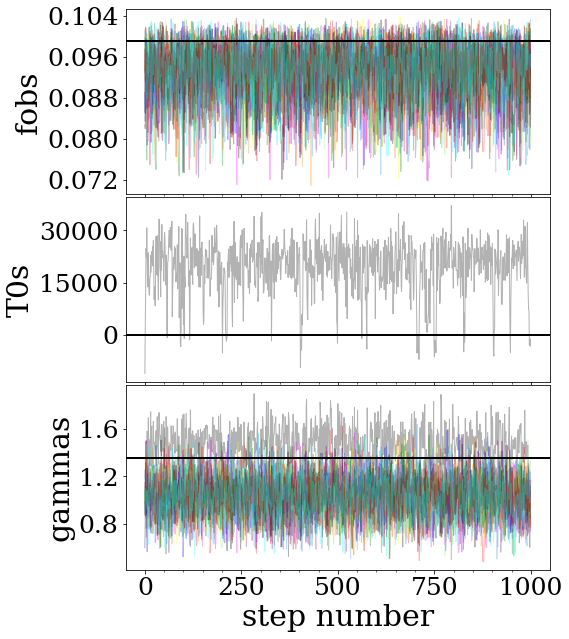

In [9]:
walker_plot(np.swapaxes(x_samples, 0, 1), var_label,
                    truths= jnp.asarray(theta_true),
                    linewidth=1.0)

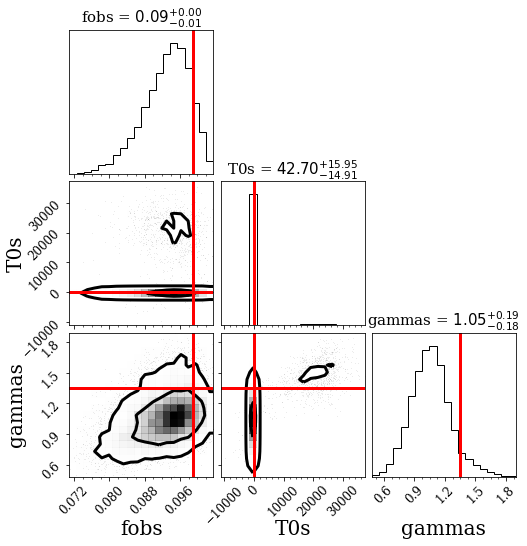

In [10]:
nn.plot_HMC(x_samples,theta_samples,theta_true,note)

In [11]:
print(nn.potential_fun(theta_true),
nn.log_likelihood(theta_true),
nn.eval_prior(theta_true))

-2292.2179086564706 2298.0737202658856 -5.855811609415321


In [12]:
from nn_hmc_3d_x import NN_HMC_X
nn_x = NN_HMC_X(vbins,best_params,T0s,gammas,fobs,like_dict)
print(nn_x.potential_fun(x_true),
nn_x.log_likelihood(x_true),
nn_x.eval_prior(x_true))

-2292.2179086564706 2298.073720265886 -5.855811609415321


In [13]:
print(nn_x.x_to_theta(x_true), theta_true, nn.theta_to_x(theta_true),x_true)

[ 0.099     63.5356931  1.352    ] [0.099, 63.53569309711353, 1.3520000000000003] [1.94591015e+00 2.00352811e+00 4.44089210e-16] [1.94591015e+00 2.00352811e+00 4.44089210e-16]


In [14]:
x_samples, theta_samples, lnP, neff, neff_mean, sec_per_neff, ms_per_step, r_hat, r_hat_mean, \
            hmc_num_steps, hmc_tree_depth, total_time = nn_x.mcmc_one(key, x_true, flux)

true theta:[ 0.099     63.5356931  1.352    ]
true x:[1.94591015e+00 2.00352811e+00 4.44089210e-16]


sample: 100%|██████████| 2000/2000 [05:49<00:00,  5.72it/s]


*** SUMMARY FOR HMC ***
total_time = 358.032279253006 seconds for the HMC
total_steps = 87054 total steps
ms_per_step = 4.112760806545431 ms per step of the HMC
n_eff_mean = 9170.666666666666 effective sample size, compared to ntot = 16000 total samples.
ms_per_neff = 39.041 ms per effective sample
r_hat_mean = 1.0
max_tree_depth encountered = 5 in chain
There were 0 transitions that exceeded the max_tree_depth = (8, 10)
*************************


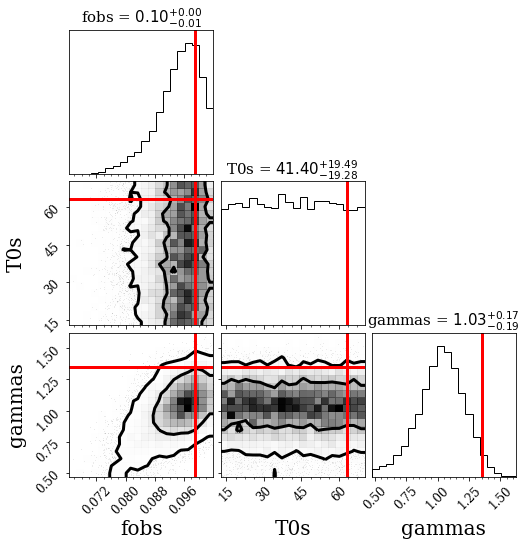

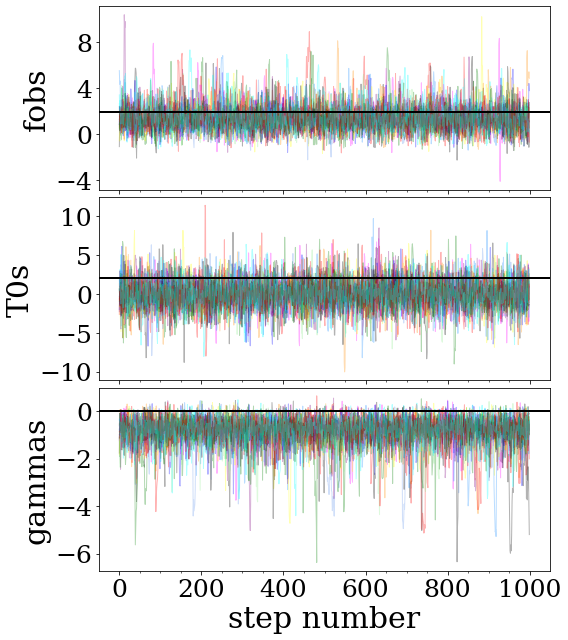

In [15]:
corner_plot(theta_samples, var_label,
            theta_true=jnp.asarray(theta_true),
            overlay_color = ['k'])
walker_plot(np.swapaxes(x_samples, 0, 1), var_label,
                    truths= jnp.asarray(x_true),
                    linewidth=1.0)

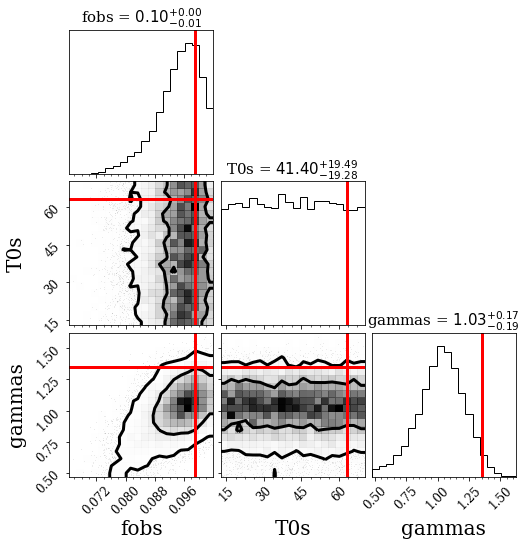

In [16]:
nn_x.plot_HMC(x_samples,theta_samples,theta_true,"jit_2000_16_test8_vec_dimensionless")